# **DATASET:**

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip /content/drive/MyDrive/dataset.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/organized_annotations/thick_line/img002768.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002769.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002772.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002774.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002775.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002776.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002777.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002778.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002780.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002784.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002785.xml  
  inflating: /content/dataset/organized_annotations/thick_line/img002786.xml  
 

In [3]:
!pip install torch torchvision tqdm matplotlib

# **SOLAR PANEL DATASET**

In [4]:
import os
import torch
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.transforms import functional as F

class SolarPanelDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.transforms = transforms
        self.images = []
        self.annotations = []

        # Directories for images and annotations (flat structure)
        image_dir = os.path.join(root, "organized_images")
        annotation_dir = os.path.join(root, "organized_annotations")

        # Get all images and annotations
        images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        annotations = sorted([f for f in os.listdir(annotation_dir) if f.endswith('.xml')])

        # Match filenames
        self.images = [
            os.path.join(image_dir, f) for f in images if f.replace('.jpg', '.xml') in annotations
        ]
        self.annotations = [
            os.path.join(annotation_dir, f) for f in annotations if f.replace('.xml', '.jpg') in images
        ]

        # Debugging print statements
        print(f"Images found: {len(self.images)}")
        print(f"Annotations found: {len(self.annotations)}")

        assert len(self.images) == len(self.annotations), "Mismatched images and annotations!"

    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        ann_path = self.annotations[idx]

        img = Image.open(img_path).convert("RGB")
        img = F.to_tensor(img)

        # Normalize the image
        img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        # Parse XML annotation
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        label_map = {
            "background": 0,
            "black_core": 1,
            "corner": 2,
            "crack": 3,
            "finger": 4,
            "fragment": 5,
            "horizontal_dislocation": 6,
            "printing_error": 7,
            "scratch": 8,
            "short_circuit": 9,
            "star_crack": 10,
            "thick_line": 11,
            "vertical_dislocation": 12,
        }

        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in label_map:
                print(f"Skipped unknown class: {class_name}")
                continue

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # Ensure the box has non-zero width and height
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label_map[class_name])

        # Handle empty annotations (e.g., images with no valid objects)
        if len(boxes) == 0:
            boxes = torch.tensor([[0, 0, 1, 1]], dtype=torch.float32)
            labels = torch.tensor([0], dtype=torch.int64)  # Background class

        # Filter out small bounding boxes (e.g., width or height < 1 pixel)
        valid_boxes = []
        valid_labels = []
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            if xmax - xmin > 1 and ymax - ymin > 1:  # Width and height > 1
                valid_boxes.append([xmin, ymin, xmax, ymax])
                valid_labels.append(label)

        # Update boxes and labels with valid ones
        if len(valid_boxes) > 0:
            boxes = torch.tensor(valid_boxes, dtype=torch.float32)
            labels = torch.tensor(valid_labels, dtype=torch.int64)
        else:
            boxes = torch.tensor([[0, 0, 1, 1]], dtype=torch.float32)  # Dummy box
            labels = torch.tensor([0], dtype=torch.int64)  # Background class

        # Construct the target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.images)


# **Spliting**

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define dataset paths
dataset_root = "/content/dataset"
images_path = os.path.join(dataset_root, "organized_images")
annotations_path = os.path.join(dataset_root, "organized_annotations")

# Create train/test directories
os.makedirs("/content/train/organized_images", exist_ok=True)
os.makedirs("/content/train/organized_annotations", exist_ok=True)
os.makedirs("/content/test/organized_images", exist_ok=True)
os.makedirs("/content/test/organized_annotations", exist_ok=True)

# Gather all images and annotations
all_images = []
all_annotations = []

for subfolder in os.listdir(images_path):
    subfolder_images = os.path.join(images_path, subfolder)
    subfolder_annotations = os.path.join(annotations_path, subfolder)

    if os.path.isdir(subfolder_images) and os.path.isdir(subfolder_annotations):
        images = sorted([os.path.join(subfolder_images, f) for f in os.listdir(subfolder_images) if f.endswith(".jpg")])
        annotations = sorted([os.path.join(subfolder_annotations, f) for f in os.listdir(subfolder_annotations) if f.endswith(".xml")])
        all_images.extend(images)
        all_annotations.extend(annotations)

# Split into train/test
train_images, test_images, train_annotations, test_annotations = train_test_split(
    all_images, all_annotations, test_size=0.2, random_state=42
)

# Move files to train/test folders
for img, ann in zip(train_images, train_annotations):
    shutil.copy(img, "/content/train/organized_images")
    shutil.copy(ann, "/content/train/organized_annotations")

for img, ann in zip(test_images, test_annotations):
    shutil.copy(img, "/content/test/organized_images")
    shutil.copy(ann, "/content/test/organized_annotations")

print(f"Train/Test splits saved to /content/train and /content/test")


Train/Test splits saved to /content/train and /content/test


In [9]:
from torch.utils.data import DataLoader

# Load train dataset
train_dataset = SolarPanelDataset(root="/content/train")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load test dataset
test_dataset = SolarPanelDataset(root="/content/test")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Images found: 3702
Annotations found: 3702
Images found: 926
Annotations found: 926
Train dataset size: 3702
Test dataset size: 926


# **Pretrained model**

In [6]:
from torchvision.models.detection import ssd300_vgg16

# Load the SSD300 model pretrained on COCO
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = ssd300_vgg16(pretrained=True)
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 213MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# **Training**

I used 4 training codes my goal to save the chickpoints after every epoch and I save its wieghts in the end so the errors its not an errors , i just stopped the train and saved the whights using last chickpoint

In [ ]:
from torchvision.models.detection import ssd300_vgg16
import torch
from tqdm import tqdm
from google.colab import drive
import torchvision.ops as ops

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving checkpoints
checkpoint_path = '/content/drive/MyDrive/ssd_checkpoint.pth'

# Load pretrained SSD model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = ssd300_vgg16(pretrained=True)
model.to(device)

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Initialize variables for resuming training
start_epoch = 0

# Check if a checkpoint exists and load it
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found. Starting training from scratch.")

# Training loop
num_epochs = 120
for epoch in range(start_epoch, num_epochs):  # Start from the checkpoint epoch
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in tqdm(train_loader):
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()
        epoch_loss += losses.item()

    # Calculate training accuracy (IoU-based)
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu()
                gt_boxes = target['boxes'].cpu()

                # Calculate IoU for each prediction and ground truth
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    ious = ops.box_iou(pred_boxes, gt_boxes)
                    correct_predictions += (ious.max(dim=1)[0] > 0.5).sum().item()  # IoU > 0.5 is correct
                total_predictions += len(gt_boxes)
    model.train()  # Switch back to training mode

    # Calculate accuracy
    training_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    # Print loss and accuracy
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {training_accuracy:.4f}")

    # Step the scheduler
    scheduler.step()

    # Save checkpoint after each epoch
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'loss': epoch_loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

# Save final model weights
torch.save(model.state_dict(), '/content/drive/MyDrive/ssd_model_final10.pth')
print("Final model saved.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-36-b732e00511d8>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


KeyError: 'optimizer_state'

In [ ]:
from torchvision.models.detection import ssd300_vgg16
import torch
from tqdm import tqdm
from google.colab import drive
import torchvision.ops as ops

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving checkpoints
checkpoint_path = '/content/drive/MyDrive/ssd_checkpoint.pth'

# Load pretrained SSD model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = ssd300_vgg16(pretrained=True)
model.to(device)

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Initialize variables for resuming training
start_epoch = 0

# Check if a checkpoint exists and load it
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state'])
    if 'optimizer_state' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint.get('epoch', -1) + 1
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found. Starting training from scratch.")
except KeyError as e:
    print(f"Checkpoint missing key: {e}. Starting training from scratch.")

# Training loop
num_epochs = 130
for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        epoch_loss += losses.item()

    model.eval()
    with torch.no_grad():
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu()
                gt_boxes = target['boxes'].cpu()

                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    ious = ops.box_iou(pred_boxes, gt_boxes)
                    correct_predictions += (ious.max(dim=1)[0] > 0.5).sum().item()
                total_predictions += len(gt_boxes)

    training_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {training_accuracy:.4f}")
    scheduler.step()

    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'loss': epoch_loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

torch.save(model.state_dict(), '/content/drive/MyDrive/ssd_model_final10.pth')
print("Final model saved.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-43-5d8b70888bbd>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 126


100%|██████████| 926/926 [03:27<00:00,  4.46it/s]


Epoch [127/130], Loss: 158.6242, Accuracy: 1.1600
Checkpoint saved at epoch 127


100%|██████████| 926/926 [03:27<00:00,  4.47it/s]


Epoch [128/130], Loss: 157.2811, Accuracy: 1.1411
Checkpoint saved at epoch 128


100%|██████████| 926/926 [03:27<00:00,  4.47it/s]


Epoch [129/130], Loss: 156.9578, Accuracy: 1.1440
Checkpoint saved at epoch 129


 65%|██████▌   | 605/926 [02:15<01:11,  4.46it/s]


KeyboardInterrupt: 

In [ ]:
from torchvision.models.detection import ssd300_vgg16
import torch
from tqdm import tqdm
from google.colab import drive
import torchvision.ops as ops
import matplotlib.pyplot as plt
import csv

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving checkpoints and logs
checkpoint_path = '/content/drive/MyDrive/ssd_checkpoint.pth'
final_model_path = '/content/drive/MyDrive/ssd_model_final8.pth'
metrics_csv_path = '/content/drive/MyDrive/training_metrics.csv'
plot_path = '/content/drive/MyDrive/training_metrics.png'

# Load pretrained SSD model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = ssd300_vgg16(pretrained=True)
model.to(device)

# Freeze backbone layers for fine-tuning
for param in model.backbone.parameters():
    param.requires_grad = False

# Unfreeze classification head for fine-tuning
for param in model.head.parameters():
    param.requires_grad = True

# Define the optimizer
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Initialize variables for resuming training
start_epoch = 0

# Check if a checkpoint exists and load it
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    print("No checkpoint found. Starting training from scratch.")

# Initialize lists to store loss and accuracy values
epoch_losses = []
epoch_accuracies = []

# Create CSV file for logging metrics
with open(metrics_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Loss', 'Accuracy'])

# Training loop
num_epochs = 130
for epoch in range(start_epoch, num_epochs):  # Start from the checkpoint epoch
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_ground_truths = 0

    for images, targets in tqdm(train_loader):
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        optimizer.step()
        epoch_loss += losses.item()

    # Calculate training accuracy (IoU-based)
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu()
                gt_boxes = target['boxes'].cpu()

                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    # Match predictions to ground truth using IoU
                    ious = ops.box_iou(pred_boxes, gt_boxes)
                    max_ious, indices = ious.max(dim=1)
                    matched_gt = set()

                    for i, iou in enumerate(max_ious):
                        if iou > 0.5 and indices[i].item() not in matched_gt:
                            correct_predictions += 1
                            matched_gt.add(indices[i].item())

                total_ground_truths += len(gt_boxes)
            else:
                # Log mismatched cases for debugging
                if len(pred_boxes) == 0:
                    print(f"No predictions for targets: {len(gt_boxes)} at batch")

    model.train()  # Switch back to training mode

    # Calculate accuracy
    training_accuracy = correct_predictions / total_ground_truths if total_ground_truths > 0 else 0

    # Log loss and accuracy
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(training_accuracy)

    # Write metrics to CSV
    with open(metrics_csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, epoch_loss, training_accuracy])

    # Print loss and accuracy
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {training_accuracy:.4f}")

    # Step the scheduler
    scheduler.step()

    # Save checkpoint after each epoch
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'loss': epoch_loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

# Save final model weights
torch.save(model.state_dict(), final_model_path)
print("Final model saved.")

# Plot and save training metrics
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

# Save the plot
plt.tight_layout()
plt.savefig(plot_path)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-42-7a053bea1463>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 120


100%|██████████| 926/926 [02:05<00:00,  7.39it/s]


Epoch [121/130], Loss: 148.8700, Accuracy: 0.9991
Checkpoint saved at epoch 121


100%|██████████| 926/926 [02:04<00:00,  7.45it/s]


Epoch [122/130], Loss: 135.9363, Accuracy: 0.9992
Checkpoint saved at epoch 122


100%|██████████| 926/926 [02:05<00:00,  7.39it/s]


Epoch [123/130], Loss: 135.4440, Accuracy: 0.9992
Checkpoint saved at epoch 123


100%|██████████| 926/926 [02:06<00:00,  7.33it/s]


Epoch [124/130], Loss: 133.0638, Accuracy: 0.9992
Checkpoint saved at epoch 124


100%|██████████| 926/926 [02:05<00:00,  7.39it/s]


Epoch [125/130], Loss: 133.6844, Accuracy: 0.9992
Checkpoint saved at epoch 125


100%|██████████| 926/926 [02:05<00:00,  7.39it/s]


Epoch [126/130], Loss: 130.3223, Accuracy: 0.9991
Checkpoint saved at epoch 126


  7%|▋         | 67/926 [00:09<01:57,  7.29it/s]


KeyboardInterrupt: 

In [ ]:
print(f"Batch size for train_loader: {train_loader.batch_size}")
print(f"Batch size for test_loader: {test_loader.batch_size}")


Batch size for train_loader: 4
Batch size for test_loader: 4


In [ ]:
# Check for overlapping filenames
train_files = set([os.path.basename(f) for f in train_dataset.images])
test_files = set([os.path.basename(f) for f in test_dataset.images])

overlap = train_files.intersection(test_files)

if overlap:
    print(f"Found {len(overlap)} overlapping samples between train and test datasets!")
    print("Overlapping files:", overlap)
else:
    print("No overlapping samples between train and test datasets.")


No overlapping samples between train and test datasets.


# **Loading the trained model**

here I saved the whights

In [21]:
from torchvision.models.detection import ssd300_vgg16
import torch

# Load trained model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = ssd300_vgg16(pretrained=False)  # Set pretrained=False since we load trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/ssd_model_final10.pth'))
model.to(device)
model.eval()  # Set model to evaluation mode
print("Model loaded successfully!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-21-0b604c831be0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Model loaded successfully!


In [ ]:
# Save the model weights
torch.save(model.state_dict(), '/content/drive/MyDrive/ssd_model_final10.pth')
print("Model weights saved successfully.")


Model weights saved successfully.


In [22]:
# Get file names from train and test datasets
train_images = set([os.path.basename(img) for img in train_dataset.images])
test_images = set([os.path.basename(img) for img in test_dataset.images])

# Find overlaps
overlaps = train_images.intersection(test_images)

if len(overlaps) > 0:
    print(f"Overlap found! {len(overlaps)} overlapping images: {overlaps}")
else:
    print("No overlapping images found between train and test datasets.")


No overlapping images found between train and test datasets.


# **Testing**

convert to .PT to isolate the training and the testing
the model is trained in .pth then load it wightes to .pt file and tested.

In [7]:
import torch
from torchvision.models.detection import ssd300_vgg16

# Path to your saved .pth model
saved_model_path = '/content/drive/MyDrive/ssd_model_final10.pth'

# Load the SSD model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = ssd300_vgg16(pretrained=False)  # Load the architecture without pre-trained weights
model.load_state_dict(torch.load(saved_model_path))  # Load the saved weights
model.to(device)

# Save the model in .pt format
pt_model_path = '/content/drive/MyDrive/ssd_model_final12.pt'
torch.save(model, pt_model_path)

print(f"Model saved in .pt format at: {pt_model_path}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:22<00:00, 24.3MB/s]
<ipython-input-7-03bd212f15d2>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions tha

Model saved in .pt format at: /content/drive/MyDrive/ssd_model_final12.pt


<ipython-input-18-41df96671d59>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(pt_model_path, map_location='cpu')


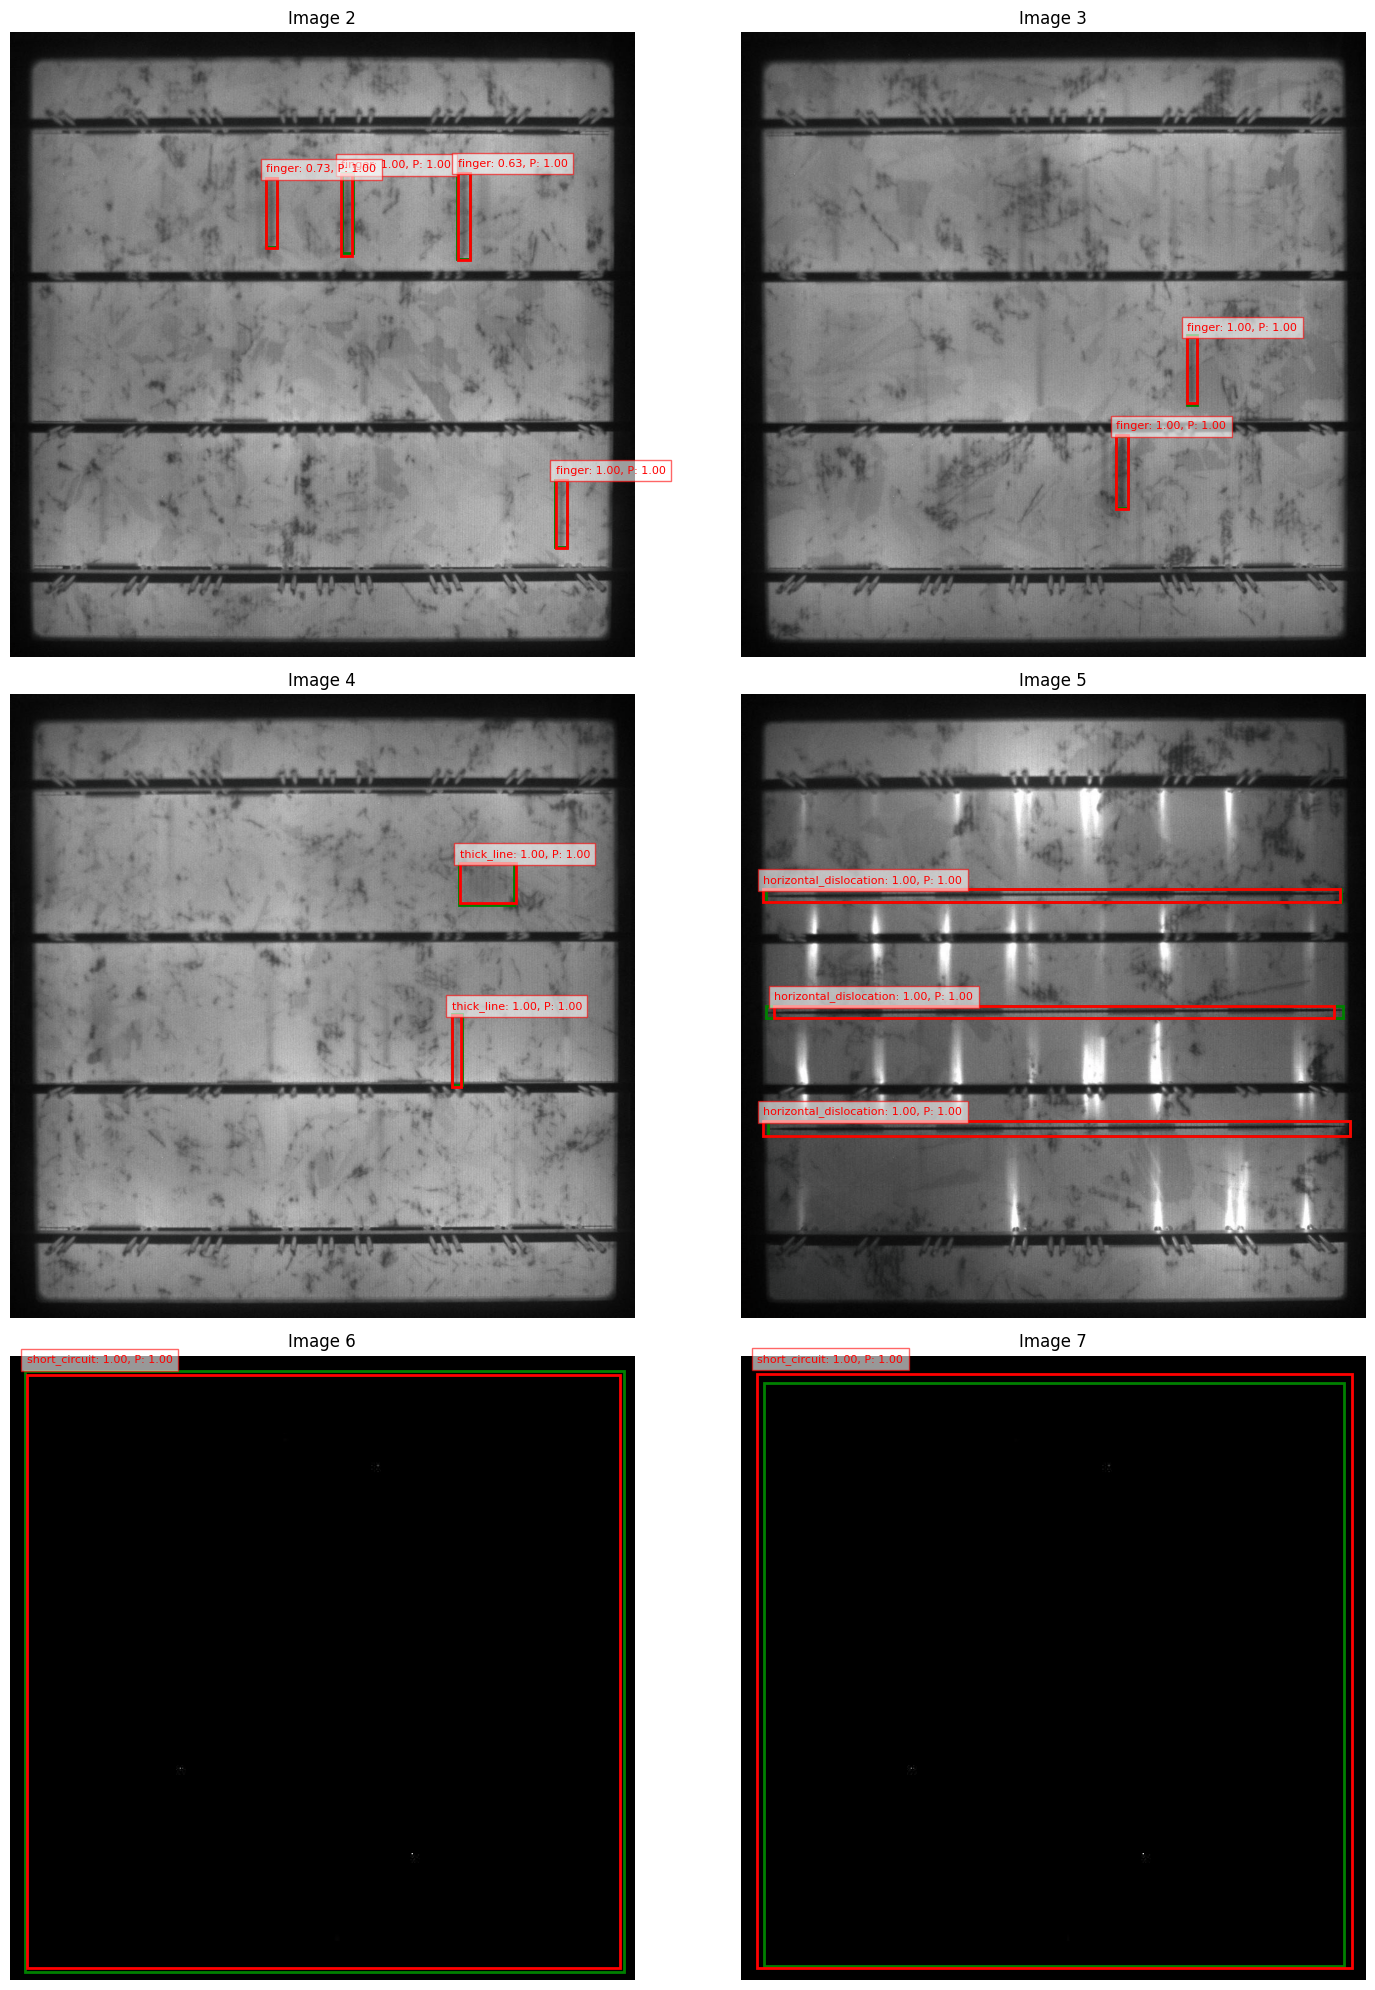

True Positives: 1629
False Positives: 77
False Negatives: 19
Precision: 0.9549
Recall: 0.9885
F1 Score: 0.9714
mAP: 0.9762


In [18]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import numpy as np
import torchvision.ops as ops
from xml.etree import ElementTree as ET
import torch
from random import sample

# Load the .pt model
pt_model_path = '/content/drive/MyDrive/ssd_model_final12.pt'
model = torch.load(pt_model_path, map_location='cpu')
model.eval()  # Set the model to evaluation mode

# Metrics Initialization
confidence_threshold = 0.1  # Lower confidence threshold
iou_threshold = 0.5  # Fixed IoU threshold
defect_map = []  # Store precision-recall pairs for mAP calculation

# Denormalization Parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    """Denormalize the image tensor for visualization."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

def get_defect_name(xml_path):
    """Parse the XML file to extract defect names."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    defect_names = [obj.find("name").text for obj in root.findall("object")]
    return defect_names

# Calculate Average Precision (AP) for a specific IoU threshold
def calculate_ap(gt_boxes, pred_boxes, pred_scores, iou_threshold):
    tp, fp, matched_gt = 0, 0, set()
    pred_sorted = sorted(zip(pred_boxes, pred_scores), key=lambda x: -x[1])  # Sort by score descending

    for pred_box, _ in pred_sorted:
        matched = False
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue

            iou = ops.box_iou(torch.tensor([gt_box]), torch.tensor([pred_box])).item()
            if iou >= iou_threshold:
                tp += 1
                matched_gt.add(gt_idx)
                matched = True
                break

        if not matched:
            fp += 1

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / len(gt_boxes) if len(gt_boxes) > 0 else 0
    return precision, recall

# Initialize metrics
true_positive = 0
false_positive = 0
false_negative = 0

# Iterate over test_loader directly
num_samples = 6
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, collate_fn=lambda x: tuple(zip(*x)))
visualized_indices = sample(range(len(test_loader.dataset)), num_samples)

# Visualize predictions
plt.figure(figsize=(15, 20))
plot_idx = 1
max_plots = 6

for idx, (images, targets) in enumerate(test_loader):
    images = [img for img in images]
    targets = [{k: v for k, v in t.items()} for t in targets]

    # Make predictions
    with torch.no_grad():
        outputs = model(images)

    for i in range(len(images)):
        img = images[i]
        denorm_img = denormalize(img.clone(), mean, std)
        gt_boxes = targets[i]['boxes'].numpy() if 'boxes' in targets[i] else []
        pred_boxes = outputs[i]['boxes'].numpy() if 'boxes' in outputs[i] else []
        pred_scores = outputs[i]['scores'].numpy() if 'scores' in outputs[i] else []

        # Extract defect names
        defect_names = get_defect_name(test_dataset.annotations[idx])

        # Filter predictions by confidence threshold
        pred_boxes = pred_boxes[pred_scores > confidence_threshold]
        pred_scores = pred_scores[pred_scores > confidence_threshold]

        # Calculate AP for the specific IoU threshold
        precision, recall = calculate_ap(gt_boxes, pred_boxes, pred_scores, iou_threshold)
        defect_map.append((precision, recall))

        # Update global metrics
        matched_gt = set()
        for pred_box in pred_boxes:
            matched = False
            for gt_idx, gt_box in enumerate(gt_boxes):
                if gt_idx in matched_gt:
                    continue

                iou = ops.box_iou(torch.tensor([gt_box]), torch.tensor([pred_box])).item()
                if iou >= iou_threshold:
                    true_positive += 1
                    matched_gt.add(gt_idx)
                    matched = True
                    break

            if not matched:
                false_positive += 1

        false_negative += len(gt_boxes) - len(matched_gt)

        # For visualization (only 6 images)
        if idx in visualized_indices:
            img_pil = to_pil_image(denorm_img)
            plt.subplot(3, 2, plot_idx)
            plot_idx += 1
            plt.imshow(img_pil)
            plt.axis("off")
            plt.title(f"Image {plot_idx}")

            # Draw ground truth boxes (green)
            for box in gt_boxes:
                xmin, ymin, xmax, ymax = box
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                  edgecolor='green', fill=False, linewidth=2))

            # Draw predicted boxes (red with precision and defect name inside box)
            for box, score in zip(pred_boxes, pred_scores):
                xmin, ymin, xmax, ymax = box
                box_precision, _ = calculate_ap(gt_boxes, [box], [score], iou_threshold)

                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                  edgecolor='red', fill=False, linewidth=2))
                plt.text(xmin, ymin - 10, f"{defect_names[0]}: {score:.2f}, P: {box_precision:.2f}",
                         color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.6, edgecolor='red'))

            if plot_idx > max_plots:
                break

plt.tight_layout()
plt.savefig('/content/visualization_with_defect_names_and_scores.png')
plt.show()

# Final mAP Calculation
precision_recall = defect_map
avg_precision = sum([p for p, _ in precision_recall]) / len(precision_recall) if len(precision_recall) > 0 else 0

# Final Metrics
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Debugging
print(f"True Positives: {true_positive}")
print(f"False Positives: {false_positive}")
print(f"False Negatives: {false_negative}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"mAP: {avg_precision:.4f}")

# Save mAP chart
plt.figure(figsize=(8, 5))
plt.bar(["IoU 0.5"], [avg_precision], color='skyblue')
plt.title("mAP Score at IoU Threshold")
plt.ylabel("mAP")
plt.xlabel("IoU Threshold")
plt.savefig('/content/map_chart.png')
plt.show()


In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import numpy as np
import torchvision.ops as ops
import torch
from random import sample
from torch.utils.data import DataLoader

# Load the test dataset and model
test_loader = DataLoader(test_loader.dataset, batch_size=1, collate_fn=lambda x: tuple(zip(*x)))

# Load the .pt model
pt_model_path = '/content/drive/MyDrive/ssd_model_final12.pt'
model = torch.load(pt_model_path, map_location='cpu')
model.eval()

# Metrics Initialization
confidence_threshold = 0.1
iou_threshold = 0.7
defect_map = []

# Denormalization Parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

def calculate_ap(gt_boxes, pred_boxes, pred_scores, iou_threshold):
    tp, fp, matched_gt = 0, 0, set()
    pred_sorted = sorted(zip(pred_boxes, pred_scores), key=lambda x: -x[1])
    for pred_box, _ in pred_sorted:
        matched = False
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue
            iou = ops.box_iou(torch.tensor([gt_box]), torch.tensor([pred_box])).item()
            if iou >= iou_threshold:
                tp += 1
                matched_gt.add(gt_idx)
                matched = True
                break
        if not matched:
            fp += 1
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / len(gt_boxes) if len(gt_boxes) > 0 else 0
    return precision, recall

# Visualize and evaluate predictions
num_samples = 6
visualized_indices = sample(range(len(test_loader.dataset)), num_samples)
plt.figure(figsize=(15, 20))
plot_idx = 1
max_plots = 6

for idx, (images, targets) in enumerate(test_loader):
    images = [img for img in images]
    targets = [{k: v for k, v in t.items()} for t in targets]
    with torch.no_grad():
        outputs = model(images)
    for i in range(len(images)):
        img = images[i]
        denorm_img = denormalize(img.clone(), mean, std)
        gt_boxes = targets[i]['boxes'].numpy() if 'boxes' in targets[i] else []
        pred_boxes = outputs[i]['boxes'].numpy() if 'boxes' in outputs[i] else []
        pred_scores = outputs[i]['scores'].numpy() if 'scores' in outputs[i] else []

        # Debugging statements
        print(f"Image {idx}:")
        print(f"  Ground Truth Boxes: {gt_boxes}")
        print(f"  Predicted Boxes: {pred_boxes}")
        print(f"  Predicted Scores: {pred_scores}")

        pred_boxes = pred_boxes[pred_scores > confidence_threshold]
        pred_scores = pred_scores[pred_scores > confidence_threshold]

        precision, recall = calculate_ap(gt_boxes, pred_boxes, pred_scores, iou_threshold)
        defect_map.append((precision, recall))

        if idx in visualized_indices:
            img_pil = to_pil_image(denorm_img)
            plt.subplot(3, 2, plot_idx)
            plot_idx += 1
            plt.imshow(img_pil)
            plt.axis("off")
            plt.title(f"Image {plot_idx}")

            # Draw ground truth boxes (green)
            for box in gt_boxes:
                xmin, ymin, xmax, ymax = box
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                  edgecolor='green', fill=False, linewidth=2))

            # Draw predicted boxes (red)
            for box, score in zip(pred_boxes, pred_scores):
                xmin, ymin, xmax, ymax = box
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                  edgecolor='red', fill=False, linewidth=2))
                plt.text(xmin, ymin - 10, f"{score:.2f}", color='red', fontsize=8,
                         bbox=dict(facecolor='white', alpha=0.6, edgecolor='red'))

            if plot_idx > max_plots:
                break

plt.tight_layout()
plt.savefig('/content/visualization_with_defect_names_and_scores.png')
plt.show()

# Metrics Calculation
precision_recall = defect_map
avg_precision = sum([p for p, _ in precision_recall]) / len(precision_recall) if precision_recall else 0
print(f"mAP: {avg_precision:.4f}")


<ipython-input-11-9910664e9541>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(pt_model_path, map_location='cpu')


Streaming output truncated to the last 5000 lines.
Image 109:
  Ground Truth Boxes: [[227. 172. 304. 235.]]
  Predicted Boxes: [[227.86818 172.57358 305.6065  235.0736 ]
 [616.59735 414.0038  726.8386  443.10303]]
  Predicted Scores: [0.98406917 0.0206191 ]
Image 110:
  Ground Truth Boxes: [[956. 411. 974. 563.]]
  Predicted Boxes: [[955.2087  411.59195 971.77765 563.4714 ]
 [574.32764 485.2533  590.76544 571.4059 ]]
  Predicted Scores: [0.99791414 0.4586955 ]
Image 111:
  Ground Truth Boxes: [[468. 585. 613. 610.]
 [344. 553. 467. 638.]]
  Predicted Boxes: [[466.90048 585.0862  613.2659  610.0482 ]
 [345.39157 551.53217 466.62756 639.21436]
 [342.88483 553.35876 464.48215 637.9801 ]]
  Predicted Scores: [0.98324615 0.9755221  0.01141739]
Image 112:
  Ground Truth Boxes: [[ 46.  57. 965. 986.]]
  Predicted Boxes: [[ 43.001617  59.94318  974.0115   982.7865  ]]
  Predicted Scores: [0.9999672]
Image 113:
  Ground Truth Boxes: [[590. 194. 605. 317.]
 [238. 728. 257. 799.]]
  Predicted Box

mAP: 0.9556


In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import numpy as np
import torchvision.ops as ops
import torch
from random import sample
from torch.utils.data import DataLoader
from collections import defaultdict

# Load the test dataset and model
test_loader = DataLoader(test_loader.dataset, batch_size=1, collate_fn=lambda x: tuple(zip(*x)))

# Load the .pt model
pt_model_path = '/content/drive/MyDrive/ssd_model_final12.pt'
model = torch.load(pt_model_path, map_location='cpu')
model.eval()

# Metrics Initialization
confidence_threshold = 0.1
iou_threshold = 0.5
defect_map = []
f1_scores = []
precision_values = []
recall_values = []
defect_metrics = defaultdict(list)

# Label map for defect names
label_map = {
    0: "background",
    1: "black_core",
    2: "corner",
    3: "crack",
    4: "finger",
    5: "fragment",
    6: "horizontal_dislocation",
    7: "printing_error",
    8: "scratch",
    9: "short_circuit",
    10: "star_crack",
    11: "thick_line",
    12: "vertical_dislocation",
}

def denormalize(tensor, mean, std):
    """Denormalize the image tensor for visualization."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

def calculate_ap(gt_boxes, pred_boxes, pred_scores, iou_threshold):
    """Calculate Average Precision (AP) for a specific IoU threshold."""
    tp, fp, matched_gt = 0, 0, set()
    pred_sorted = sorted(zip(pred_boxes, pred_scores), key=lambda x: -x[1])

    for pred_box, _ in pred_sorted:
        matched = False
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue
            iou = ops.box_iou(torch.tensor([gt_box]), torch.tensor([pred_box])).item()
            if iou >= iou_threshold:
                tp += 1
                matched_gt.add(gt_idx)
                matched = True
                break

        if not matched:
            fp += 1

    fn = len(gt_boxes) - len(matched_gt)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall

def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Evaluate and collect metrics
for idx, (images, targets) in enumerate(test_loader):
    images = [img for img in images]
    targets = [{k: v for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    for i in range(len(images)):
        gt_boxes = targets[i]['boxes'].numpy() if 'boxes' in targets[i] else []
        gt_labels = targets[i]['labels'].numpy() if 'labels' in targets[i] else []

        pred_boxes = outputs[i]['boxes'].numpy() if 'boxes' in outputs[i] else []
        pred_scores = outputs[i]['scores'].numpy() if 'scores' in outputs[i] else []
        pred_labels = outputs[i]['labels'].numpy() if 'labels' in outputs[i] else []

        pred_boxes = pred_boxes[pred_scores > confidence_threshold]
        pred_labels = pred_labels[pred_scores > confidence_threshold]
        pred_scores = pred_scores[pred_scores > confidence_threshold]

        for label in np.unique(gt_labels):
            gt_class_boxes = gt_boxes[gt_labels == label]
            pred_class_boxes = pred_boxes[pred_labels == label]
            pred_class_scores = pred_scores[pred_labels == label]

            precision, recall = calculate_ap(gt_class_boxes, pred_class_boxes, pred_class_scores, iou_threshold)
            f1_score = calculate_f1(precision, recall)

            defect_metrics[label_map[label]].append((precision, recall, f1_score))

# Aggregate metrics for each defect type
average_metrics = {}
for defect, metrics in defect_metrics.items():
    metrics = np.array(metrics)
    average_metrics[defect] = metrics.mean(axis=0)  # Mean of precision, recall, F1

# Visualization
labels = list(average_metrics.keys())
precision_values = [average_metrics[d][0] for d in labels]
recall_values = [average_metrics[d][1] for d in labels]
f1_values = [average_metrics[d][2] for d in labels]

x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, precision_values, width=0.2, label='Precision', color='orange')
plt.bar(x, recall_values, width=0.2, label='Recall', color='green')
plt.bar(x + 0.2, f1_values, width=0.2, label='F1-Score', color='blue')

plt.xticks(x, labels, rotation=45, ha='right')
plt.title('Model Performance by Defect Type')
plt.xlabel('Defect Type')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.savefig('/content/defect_type_performance.png')
plt.show()


<ipython-input-19-784d80c1036c>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(pt_model_path, map_location='cpu')
